<a href="https://colab.research.google.com/github/dangdang2222/LG_Aimers/blob/main/%EC%B0%B8%EA%B3%A0%EC%9A%A9_withpca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import random
import os
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

def lg_nrmse(gt, preds):
    # 각 Y Feature별 NRMSE 총합
    # Y_01 ~ Y_08 까지 20% 가중치 부여
    all_nrmse = []
    for idx in range(0,13): # ignore 'ID'
        rmse = mean_squared_error(np.array(gt)[:,idx], preds[:,idx], squared=False)
        nrmse = rmse/np.mean(np.abs(np.array(gt)[:,idx]))
        all_nrmse.append(nrmse)
    score = 1.2 * np.sum(all_nrmse[:8]) + 1.0 * np.sum(all_nrmse[8:15])
    return score

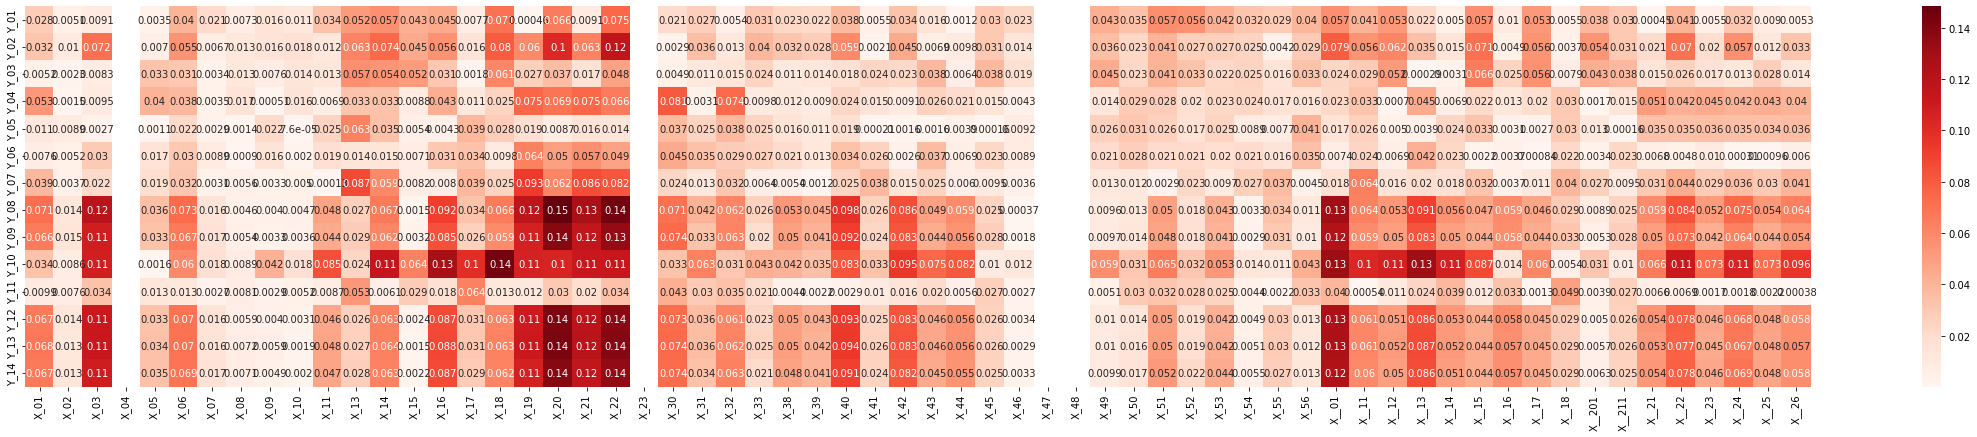

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/LG Aimer/train.csv').drop(columns="ID")

#################################################################################################################
train_df['X__01'] = train_df['X_03'] / train_df['X_07']
train_df['X_10'] = train_df['X__01'] * train_df['X_08']
train_df['X_11'] = train_df['X__01'] * train_df['X_09']

train_df['X__11'] = (train_df['X_41'] * train_df['X_14']) 
train_df['X__12'] = (train_df['X_42'] * train_df['X_15']) 
train_df['X__13'] = (train_df['X_43'] * train_df['X_16']) 
train_df['X__14'] = (train_df['X_44'] * train_df['X_17']) 
train_df['X__15'] = (train_df['X_41'] / train_df['X_14']) 
train_df['X__16'] = (train_df['X_42'] / train_df['X_15']) 
train_df['X__17'] = (train_df['X_43'] / train_df['X_16']) 
train_df['X__18'] = (train_df['X_44'] / train_df['X_17'])

train_df['X__201'] = train_df.loc[:,['X_19','X_20','X_21','X_22']].max(axis=1) - train_df.loc[:,['X_19','X_20','X_21','X_22']].min(axis=1)
train_df['X__211'] = train_df.loc[:,['X_41','X_42','X_43','X_44']].max(axis=1) - train_df.loc[:,['X_41','X_42','X_43','X_44']].min(axis=1)
# 커넥터 핀 휨 
train_df['X__21'] = (train_df['X_24'] - train_df['X_12'])
train_df['X__22'] = (train_df['X_25'] - train_df['X_12'])
train_df['X__23'] = (train_df['X_26'] - train_df['X_12'])
train_df['X__24'] = (train_df['X_27'] - train_df['X_12'])
train_df['X__25'] = (train_df['X_28'] - train_df['X_12'])
train_df['X__26'] = (train_df['X_29'] - train_df['X_12'])

# 커넥터 위치 좌표, 각 커넥터 수치 drop
train_df.drop(labels = ['X_12','X_24','X_25','X_26','X_27','X_28','X_29'], axis=1, inplace=True)

# 스크류 체결 시 분당 회전수 drop
train_df.drop(labels = ['X_34','X_35','X_36','X_37'], axis=1, inplace=True)
#################################################################################################################

cor_pass = train_df.corr(method='pearson')
cor_pass = xycor_pass = cor_pass.filter(regex='X').filter(regex='Y', axis=0)
plt.rcParams["figure.figsize"] = (40,7)
sns.heatmap(xycor_pass.abs(),
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Reds', #색상
          )




In [ ]:
drop_cols = ['X_14','X_15','X_16','X_17','X_18']
train_x = train_df.filter(regex='X') # Input : X Featrue
train_y = train_df.filter(regex='Y') # Output : Y Feature
train_x = train_x.drop(columns=drop_cols)



In [ ]:
train_y04 = train_y['Y_04']

In [ ]:
train_x

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X__17,X__18,X__201,X__211,X__21,X__22,X__23,X__24,X__25,X__26
0,70.544,103.320,67.47,1,101.892,74.983,29.45,62.38,245.71,142.912686,...,1.588060,1.559911,0.11,0.29,-2.29,-2.27,-2.29,-2.28,-2.28,-1.99
1,69.524,103.321,65.17,1,101.944,72.943,28.73,61.23,233.61,138.891719,...,1.572065,1.564027,0.29,0.13,-2.28,-2.28,-2.28,-2.28,-2.21,-2.10
2,72.583,103.320,64.07,1,103.153,72.943,28.81,105.77,272.20,235.219851,...,1.581031,1.563286,0.11,0.14,-2.29,-2.30,-2.32,-2.29,-2.26,-2.10
3,71.563,103.320,67.57,1,101.971,77.022,28.92,115.21,255.36,269.181871,...,1.583271,1.561066,0.07,0.22,-2.27,-2.28,-2.30,-2.27,-2.26,-2.21
4,69.524,103.320,63.57,1,101.981,70.904,29.68,103.38,241.46,221.424077,...,1.579418,1.562963,0.12,0.22,-2.26,-2.29,-2.26,-2.23,-2.02,-2.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,103.320,62.27,1,103.150,66.825,30.20,77.83,298.05,160.479275,...,1.568468,1.567308,0.17,0.11,-2.26,-2.25,-2.28,-2.25,-2.26,-2.16
39603,66.465,103.321,62.77,1,102.021,66.825,29.21,102.25,270.67,219.727234,...,1.574610,1.570793,0.10,0.12,-2.28,-2.28,-2.31,-2.28,-2.29,-2.20
39604,68.504,103.320,64.67,1,103.144,68.864,29.96,102.61,198.07,221.488274,...,1.575353,1.567308,0.16,0.13,-2.25,-2.29,-2.30,-2.31,-2.26,-2.22
39605,66.465,103.320,63.67,1,102.025,67.845,30.30,112.60,275.52,236.608647,...,1.573234,1.562870,0.17,0.11,-2.26,-2.30,-2.28,-2.28,-2.23,-2.21


In [ ]:
train_x_temp = train_x.loc[:,['X_04','X_23','X_47','X_48']]
train_x= train_x.drop(columns=['X_04','X_23','X_47','X_48'])
#pca 전에 데이터 스케일링을 해야함

In [ ]:
train_x.columns

Index(['X_01', 'X_02', 'X_03', 'X_05', 'X_06', 'X_07', 'X_08', 'X_09', 'X_10',
       'X_11', 'X_13', 'X_19', 'X_20', 'X_21', 'X_22', 'X_30', 'X_31', 'X_32',
       'X_33', 'X_38', 'X_39', 'X_40', 'X_41', 'X_42', 'X_43', 'X_44', 'X_45',
       'X_46', 'X_49', 'X_50', 'X_51', 'X_52', 'X_53', 'X_54', 'X_55', 'X_56',
       'X__01', 'X__11', 'X__12', 'X__13', 'X__14', 'X__15', 'X__16', 'X__17',
       'X__18', 'X__201', 'X__211', 'X__21', 'X__22', 'X__23', 'X__24',
       'X__25', 'X__26'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


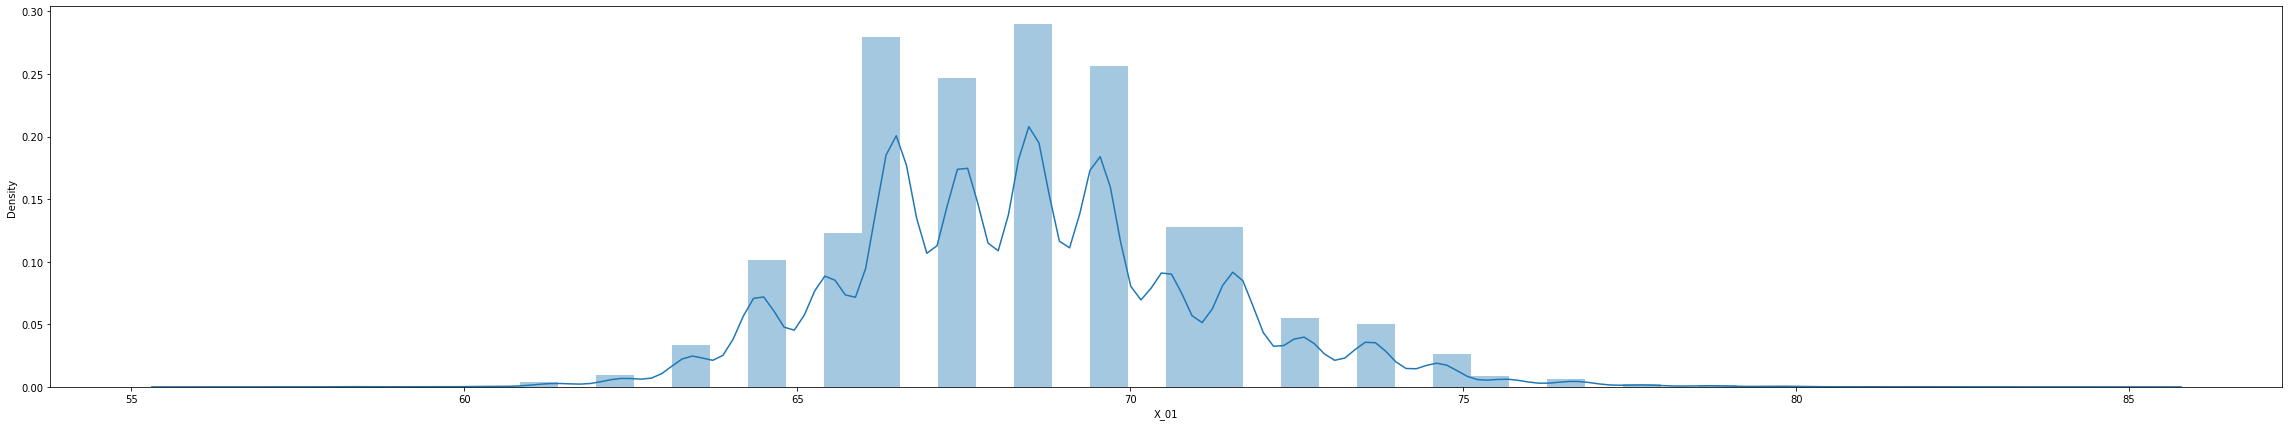

In [ ]:
import seaborn as sns
columns = train_x.columns
sns.distplot(train_x['X_01'])


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


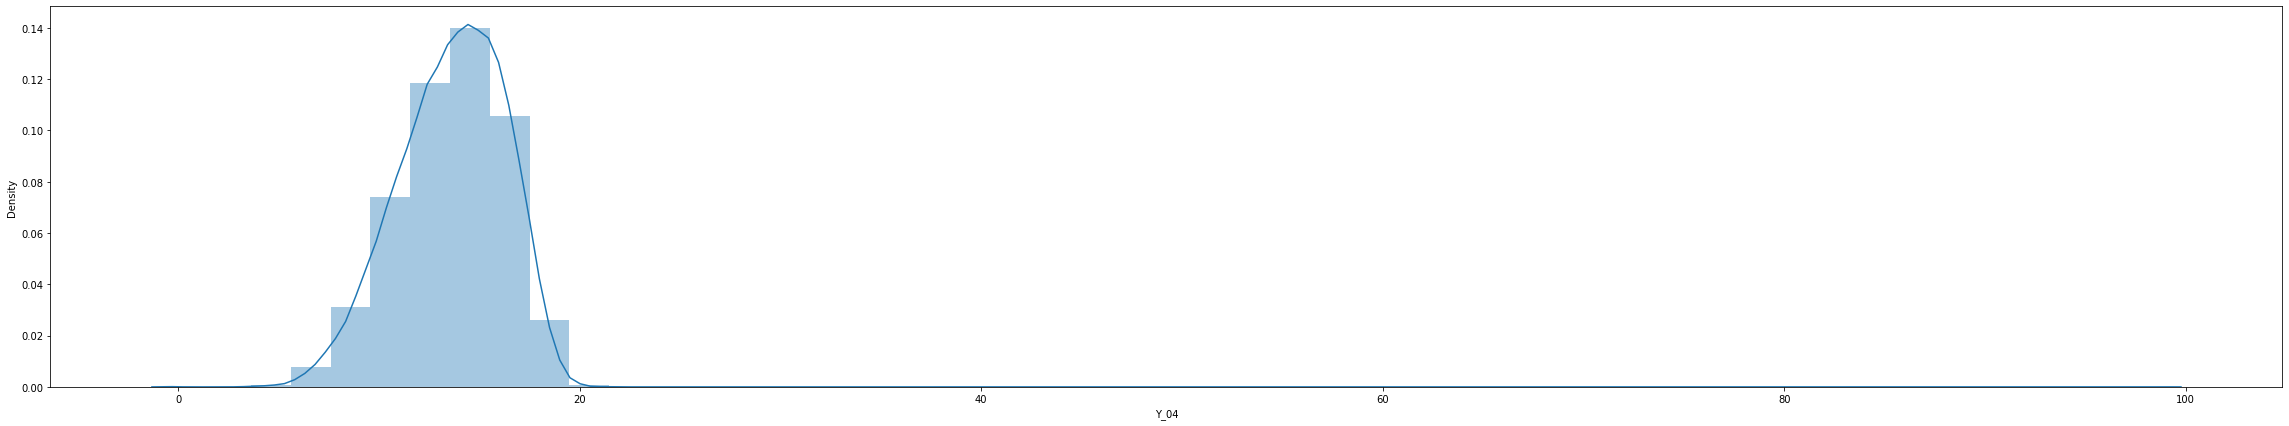

In [ ]:
sns.distplot(train_y04)
#no logarithm needed...


In [ ]:
print(train_y04.skew())
print(train_y04.kurt())

0.4534505598217596
25.18483477278538


In [ ]:
train_x['X_01'].skew()

0.47493638653762155

In [ ]:
#y__04는 이미 정규분포를 따른다. 따라서 굳이 logarithm 변환을 해줄 이유는 없다!

In [ ]:
#아웃라이어가 있으므로... robustscaler을 써준다. 다만 tree 타입에서는 스케일링 딱히 해줄 이유는 없긴하다
#pca할때는 스케일링을 해주는게 맞다... 따라서 이때는 일단 scaling 진행
#현재 train_x에는 1이 없는 상황임

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_x = scaler.fit_transform(train_x)
scaled_train_x 


array([[ 0.80271132, -0.44663762, -0.26331332, ..., -0.12968692,
        -0.58426843,  4.42447028],
       [ 0.4186678 ,  2.23895159, -0.70981974, ..., -0.12968692,
         1.02804819,  2.10136877],
       [ 1.57042184, -0.44663762, -0.9233663 , ..., -0.38795873,
        -0.12360654,  2.10136877],
       ...,
       [ 0.03462428, -0.44663762, -0.80688636, ..., -0.90450235,
        -0.12360654, -0.43292378],
       [-0.73308623, -0.44663762, -1.00101959, ..., -0.12968692,
         0.5673863 , -0.22173274],
       [-0.73308623, -0.44663762, -0.61275313, ..., -1.42104597,
         0.10672441, -0.22173274]])

In [ ]:
scaled_train_x = pd.DataFrame(scaled_train_x, index= train_x.index, columns = train_x.columns)
scaled_train_x

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_10,X_11,...,X__17,X__18,X__201,X__211,X__21,X__22,X__23,X__24,X__25,X__26
0,0.802711,-0.446638,-0.263313,-0.811901,1.940794,0.005793,-0.463110,0.304381,-0.473368,0.176740,...,2.755786,-1.919232,-0.473253,2.883580,-1.041763,0.287323,-0.188554,-0.129687,-0.584268,4.424470
1,0.418668,2.238952,-0.709820,-0.717070,1.038055,-0.092325,-0.468328,0.123064,-0.481146,-0.027625,...,-0.585992,-0.612893,2.753888,-0.523073,-0.720687,-0.020519,0.075195,-0.129687,1.028048,2.101369
2,1.570422,-0.446638,-0.923366,1.487741,1.038055,-0.081423,-0.266241,0.701331,-0.294824,0.439349,...,1.287163,-0.847850,-0.473253,-0.310157,-1.041763,-0.636203,-0.979804,-0.387959,-0.123607,2.101369
3,1.186378,-0.446638,-0.243900,-0.667831,2.843089,-0.066433,-0.223409,0.448985,-0.229133,0.385453,...,1.755278,-1.552720,-1.190396,1.393169,-0.399612,-0.020519,-0.452304,0.128585,-0.123607,-0.221733
4,0.418668,-0.446638,-1.020433,-0.649595,0.135760,0.037136,-0.277084,0.240695,-0.321508,-0.106507,...,0.950302,-0.950535,-0.293967,1.393169,-0.078536,-0.328361,0.602695,1.161672,5.404336,-0.432924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,-0.733086,-0.446638,-1.272806,1.482270,-1.669274,0.107999,-0.393010,1.088690,-0.439390,0.496399,...,-1.337653,0.428597,0.602461,-0.948904,-0.078536,0.903007,0.075195,0.645129,-0.123607,0.834222
39603,-0.733086,2.238952,-1.175739,-0.576648,-1.669274,-0.026913,-0.282212,0.678404,-0.324790,0.292675,...,-0.054280,1.534984,-0.652539,-0.735989,-0.720687,-0.020519,-0.716054,-0.129687,-0.814599,-0.010542
39604,0.034624,-0.446638,-0.806886,1.471328,-0.766978,0.075293,-0.280578,-0.409499,-0.321384,-0.661384,...,0.100832,0.428597,0.423175,-0.523073,0.242539,-0.328361,-0.452304,-0.904502,-0.123607,-0.432924
39605,-0.733086,-0.446638,-1.001020,-0.569353,-1.217905,0.121627,-0.235251,0.751081,-0.292137,0.276003,...,-0.341784,-0.980100,0.602461,-0.948904,-0.078536,-0.636203,0.075195,-0.129687,0.567386,-0.221733


In [ ]:
scaled_train_x['X_02'].value_counts()

-0.446638    33020
 2.238952     6587
Name: X_02, dtype: int64

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)

pca_train_x = pca.fit_transform(scaled_train_x)
print(pca_train_x.shape)

(39607, 10)


In [ ]:
pca_train_x=pd.DataFrame(pca_train_x,index = scaled_train_x.index)
pca_train_x

,0,1,2,3,4,5,6,7,8,9
0,1.873956,-6.273214,1.186094,0.208661,-1.769624,1.365473,-1.846171,4.652822,-1.619958,-0.370791
1,1.884683,-1.046038,3.225045,-3.473639,-1.069054,0.998663,-0.707837,4.163137,-1.212189,-0.463535
2,0.553251,-1.574035,2.427018,-2.814871,-1.438198,-0.574986,1.507122,5.064719,-0.676165,0.393295
3,-0.010145,-4.923130,2.497556,-3.003669,-1.850667,1.697570,-1.397032,5.174744,-1.171735,-0.113193
4,2.487873,-4.208718,4.071953,-1.528324,-3.238617,0.425908,-0.569061,4.000867,-0.704539,-0.926859
...,...,...,...,...,...,...,...,...,...,...
39602,2.613147,1.201939,1.275368,-1.273389,1.313042,-1.537203,0.548484,0.238439,0.091880,0.889688
39603,1.519631,-0.291510,1.274679,-2.694825,2.305776,-1.166116,1.634899,0.528354,1.830299,-0.205966
39604,1.315920,0.431188,-0.483261,-1.243588,0.838600,-0.136800,1.712489,0.755177,0.026859,1.362491
39605,0.773854,-0.473367,2.597562,-1.767839,0.062661,-1.684625,1.143069,-0.126359,-0.711736,0.581976


Train it with pca_scaled_train_x

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(pca_train_x, train_y04,test_size= 0.3, random_state=10)


In [ ]:
from xgboost import XGBRegressor
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, gamma=1, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
model.fit(x_train, y_train)

y_predict = model.predict(x_test)

score = mean_squared_error(y_test, y_predict)
print(score)

[07:38:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
6.957301437635032
